In [ ]:
pip install librosa numpy pandas scikit-learn


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("vjcalling/speaker-recognition-audio-dataset")

print("Path to dataset files:", path)

100%|██████████| 3.64G/3.64G [00:34<00:00, 115MB/s] 

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/vjcalling/speaker-recognition-audio-dataset/versions/1


In [ ]:
import os
import librosa
import numpy as np

def extract_mfcc(file_path, max_length=100):
    y, sr = librosa.load(file_path, sr=22050)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)

    # Pad or truncate to ensure all MFCC features have the same length
    if mfcc.shape[1] < max_length:
        pad_width = max_length - mfcc.shape[1]
        mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')
    else:
        mfcc = mfcc[:, :max_length]

    return mfcc.flatten()

# Extract features from all audio files
dataset_dir = "/root/.cache/kagglehub/datasets/vjcalling/speaker-recognition-audio-dataset/versions/1" # Use the downloaded dataset path
features = []
labels = []

for speaker in os.listdir(dataset_dir):
    speaker_path = os.path.join(dataset_dir, speaker)
    if os.path.isdir(speaker_path):
        for file in os.listdir(speaker_path):
            if file.endswith(".wav"):
                file_path = os.path.join(speaker_path, file)
                mfcc_features = extract_mfcc(file_path)
                features.append(mfcc_features)
                labels.append(speaker)  # Use speaker name as label

# Convert to NumPy arrays
X = np.array(features)
y = np.array(labels)


In [ ]:
import os
print(os.listdir("/root/.cache/kagglehub/datasets/vjcalling/speaker-recognition-audio-dataset/versions/1"))


['50_speakers_audio_data']


Speaker Distribution:
Training set: 1506 samples, 50 unique speakers
Validation set: 502 samples, 49 unique speakers
Test set: 503 samples, 50 unique speakers


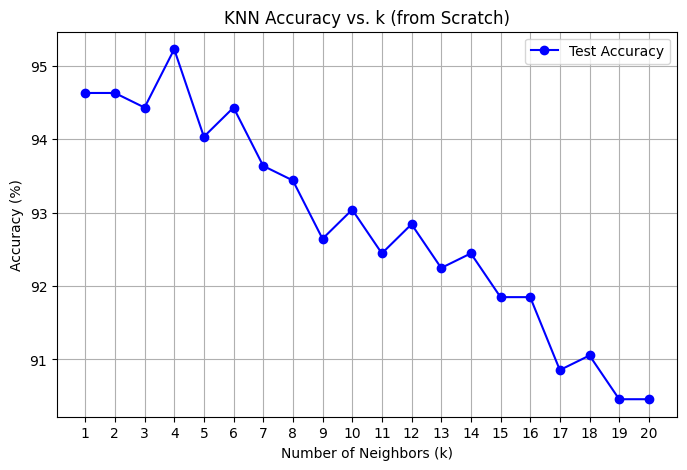

Best k: 4, Accuracy: 95.23%
Training Accuracy: 98.61%
Validation Accuracy: 93.82%
Test Accuracy: 95.23%


In [ ]:
import numpy as np
import os
import librosa
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Step 1: Dataset Path
dataset_path = "/root/.cache/kagglehub/datasets/vjcalling/speaker-recognition-audio-dataset/versions/1/50_speakers_audio_data"

# Step 2: Check if dataset exists
if not os.path.exists(dataset_path):
    raise FileNotFoundError(f"Dataset not found at {dataset_path}. Check if the download was successful.")

# Step 3: Extract MFCC Features
def extract_mfcc(file_path, n_mfcc=13):
    y, sr = librosa.load(file_path, sr=None)  # Load audio file
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)  # Extract MFCC
    return np.mean(mfcc, axis=1)  # Take mean along time axis

# Step 4: Load and Process Dataset
X, y = [], []

for speaker_folder in os.listdir(dataset_path):
    speaker_path = os.path.join(dataset_path, speaker_folder)
    if os.path.isdir(speaker_path):  # Ensure it's a valid speaker directory
        for file in os.listdir(speaker_path):
            if file.endswith(".wav"):  # Process only WAV files
                file_path = os.path.join(speaker_path, file)
                features = extract_mfcc(file_path)  # Extract MFCC
                X.append(features)
                y.append(speaker_folder)  # Use folder name as speaker label

# Step 5: Convert to NumPy Arrays
X = np.array(X)
y = np.array(y)

# Step 6: Encode Labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)  # Convert speaker names to numerical labels

# Step 7: Split Data into Training, Validation & Testing Sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Step 8: Display Class Distribution
print(f"Speaker Distribution:")
print(f"Training set: {len(y_train)} samples, {len(set(y_train))} unique speakers")
print(f"Validation set: {len(y_val)} samples, {len(set(y_val))} unique speakers")
print(f"Test set: {len(y_test)} samples, {len(set(y_test))} unique speakers")

# Step 9: KNN from Scratch
class KNN:
    def __init__(self, k=3):
        self.k = k

    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train

    def predict(self, X_test):
        return np.array([self._predict_single(x) for x in X_test])

    def _predict_single(self, x):
        distances = np.linalg.norm(self.X_train - x, axis=1)  # Euclidean distance
        k_indices = np.argsort(distances)[:self.k]  # Get indices of k nearest neighbors
        k_nearest_labels = self.y_train[k_indices]  # Get k nearest labels
        most_common = Counter(k_nearest_labels).most_common(1)
        return most_common[0][0]  # Return most common label

    def accuracy(self, X_test, y_test):
        y_pred = self.predict(X_test)
        return np.sum(y_pred == y_test) / len(y_test) * 100

# Step 10: Find the Best k
k_values = range(1, 21)
accuracies = []

for k in k_values:
    knn = KNN(k=k)
    knn.fit(X_train, y_train)
    acc = knn.accuracy(X_test, y_test)
    accuracies.append(acc)

# Step 11: Plot Accuracy vs. k-values
plt.figure(figsize=(8, 5))
plt.plot(k_values, accuracies, marker='o', linestyle='-', color='b', label="Test Accuracy")
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Accuracy (%)")
plt.title("KNN Accuracy vs. k (from Scratch)")
plt.xticks(k_values)
plt.grid(True)
plt.legend()
plt.show()

# Step 12: Find the Best k
best_k = k_values[np.argmax(accuracies)]
best_accuracy = max(accuracies)

print(f"Best k: {best_k}, Accuracy: {best_accuracy:.2f}%")

# Step 13: Compute Accuracies for Train, Validation, and Test
best_knn = KNN(k=best_k)
best_knn.fit(X_train, y_train)

train_accuracy = best_knn.accuracy(X_train, y_train)
val_accuracy = best_knn.accuracy(X_val, y_val)
test_accuracy = best_knn.accuracy(X_test, y_test)

print(f"Training Accuracy: {train_accuracy:.2f}%")
print(f"Validation Accuracy: {val_accuracy:.2f}%")
print(f"Test Accuracy: {test_accuracy:.2f}%")


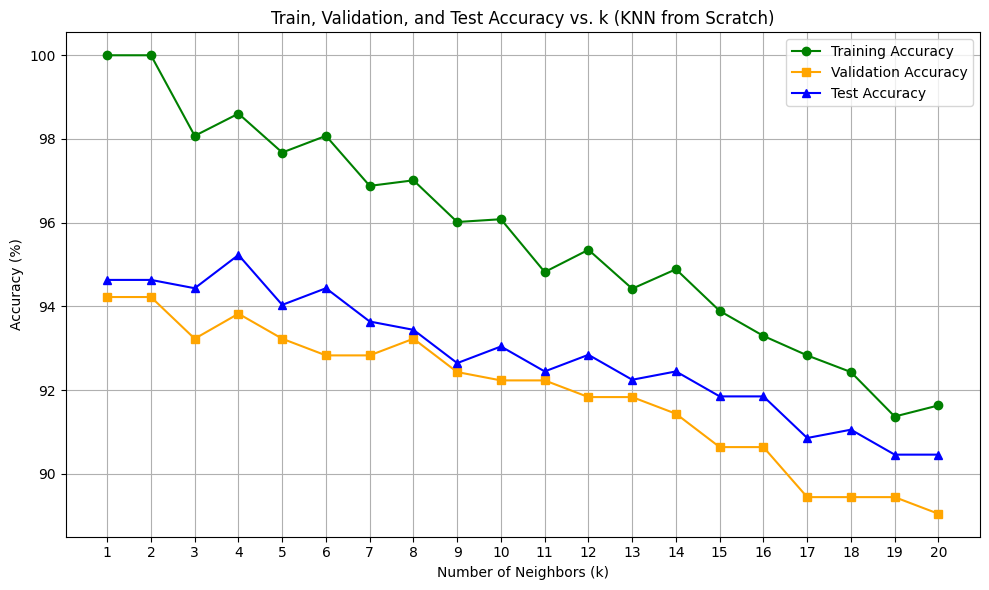

In [ ]:
train_accuracies = []
val_accuracies = []
test_accuracies = []

for k in k_values:
    knn = KNN(k=k)
    knn.fit(X_train, y_train)
    train_acc = knn.accuracy(X_train, y_train)
    val_acc = knn.accuracy(X_val, y_val)
    test_acc = knn.accuracy(X_test, y_test)

    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    test_accuracies.append(test_acc)

# Plot all accuracies together
plt.figure(figsize=(10, 6))
plt.plot(k_values, train_accuracies, marker='o', label='Training Accuracy', color='green')
plt.plot(k_values, val_accuracies, marker='s', label='Validation Accuracy', color='orange')
plt.plot(k_values, test_accuracies, marker='^', label='Test Accuracy', color='blue')
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Accuracy (%)")
plt.title("Train, Validation, and Test Accuracy vs. k (KNN from Scratch)")
plt.legend()
plt.grid(True)
plt.xticks(k_values)
plt.tight_layout()
plt.show()


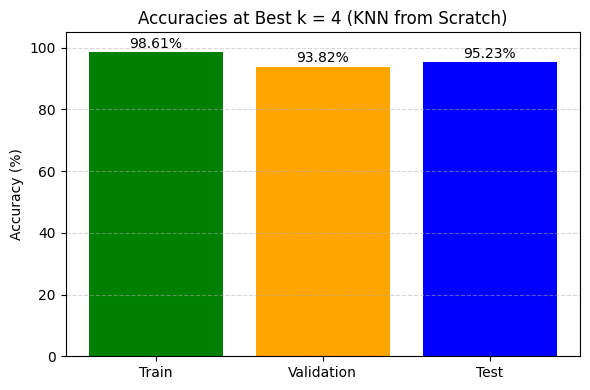

In [ ]:
# Step 14: Plot bar graph for final accuracies at best k
accuracies = [train_accuracy, val_accuracy, test_accuracy]
labels = ['Train', 'Validation', 'Test']
colors = ['green', 'orange', 'blue']

plt.figure(figsize=(6, 4))
bars = plt.bar(labels, accuracies, color=colors)

# Annotate bars with values
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, f"{acc:.2f}%",
             ha='center', va='bottom', fontsize=10)

plt.title(f"Accuracies at Best k = 4 (KNN from Scratch)")
plt.ylabel("Accuracy (%)")
plt.ylim(0, 105)
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()
